In [1]:
import sys
sys.path.append('..')
# from src.evo_eq_model import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%load_ext autoreload

In [3]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import re
import neo_originations.utils as ut
import neo_originations.plot_utils as put

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so
import scipy.stats as spst

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
sns.set_theme(context='paper')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

2024-12-10 16:27:23.840 | INFO     | neo_originations.config:<module>:11 - PROJ_ROOT path is: /Users/dennytrimcev/Dropbox/Work_Main/Thesis/2_chapter


In [4]:
from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
flupredict_to_pango = {"1":"WT",
            "1A":"A",
            "1B":"B",
            "1C":"B.1",
            "1C.2A":"B.1",
            "1C.2A.3A":"B.1",
            "1C.2A.3A.4A":"B.1.427/429",
            "1C.2A.3A.4B":"B.1.351",
            '1C.2A.3A.4C':"B.1.526",
            "1C.2B":"B1.1",
            "1C.2B.3D":"B.1.1.7",
            "1C.2B.3G":"P.1",
            "1C.2B.3J":"BA",
            "1C.2B.3J.4D":"BA.1",
            "1C.2B.3J.4D.5A":"BA.1.1",
            "1C.2B.3J.4E":"BA.2",
            "1C.2B.3J.4E.5B": "BA.2.12.1",
            "1C.2B.3J.4E.5C":"BA.2.75",
            "1C.2B.3J.4E.5C.6A":"BA.2.75.2",
            "1C.2B.3J.4E.5C.6E":"BM.1.1",
            "1C.2B.3J.4E.5C.6I.7C":"CH.1.1",
            "1C.2B.3J.4E.5C.6F":"BN.1",
            "1C.2B.3J.4E.5O":"BA.2.86",
            "1C.2B.3J.4E.5O.6L":"JN.1",
            "1C.2B.3J.4E.5O.6L.7G":"JN.1.1",
            "1C.2B.3J.4E.5O.6L.7H":"JN.1.4",
            "1C.2B.3J.4E.5O.6L.7I":"JN.1.11",
            "1C.2B.3J.4F":"BA.4",
            "1C.2B.3J.4F.5D":"BA.4.6",
            "1C.2B.3J.4G":"BA.5",
            "1C.2B.3J.4G.5E":"BF.7",
            "1C.2B.3J.4G.5F":"BQ.1",
            "1C.2B.3J.4G.5F.6B":"BQ.1.1",
            "1C.2C":"B.1.177",
            "1C.2D":"B.1.1",
            "1C.2D.3E":"B.1.617.1",
            "1C.2D.3F":"B.1.617.2",
            "1C.2A.3I":"B.1.621",
            "1C.2B.3J.4E.5N":"XBB",
            "1C.2B.3J.4E.5N.6J":"XBB.1.5",
            "1C.2B.3J.4E.5N.6J.7F":"JD.1.1",
            "1C.2B.3J.4E.5N.6J.7D":"XBB.1.9",
            "1C.2B.3J.4E.5N.6J.7D.8A":"EG.5.1",
            "1C.2B.3J.4E.5N.6J.7D.8A.9A":"HK.3",
            "1C.2B.3J.4E.5N.6J.7D.8A.9B":"HV.1",
            "1C.2B.3J.4E.5N.6J.7E":"XBB.1.16",
            "1C.2B.3J.4E.5N.6K":"XBB.2.3"}

In [6]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

output_folder= project_path+'/reports/figures/'
os.makedirs(output_folder, exist_ok = True)
data_folder = project_path+'/data/'
saves_folder= project_path + '/data/interim/'
self_generated_data = project_path + '/data/processed/'

# thesis_picture_folder = os.path.relpath("../../Thesis/figures/2_chapter/")
# assert os.path.exists(thesis_picture_folder)

In [7]:
# global_clade_stats_SARS_CoV_2_folder = project_path+'/data/global_clade_stats_SARS_CoV_2/'
global_clade_stats_SARS_CoV_2_folder = project_path+'/data/external/2024-07-15-data/'

assert os.path.exists(global_clade_stats_SARS_CoV_2_folder)

global_clade_statistics_SARS_CoV_2_World = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

global_clade_statistics_SARS_CoV_2_World = global_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

driver_mutation_statistics = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')


reference_date = pd.to_datetime('2020-01-01')
global_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(global_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

In [8]:
last_date = '2022-12-31'
#/Users/dennytrimcev/Dropbox/Work_Main/neo_originations/data/external/2024-03-04-data
covid_data = pd.read_csv(project_path+'/data/external/2024-03-04-data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

covid_data_World['day_diff'] = (pd.to_datetime(covid_data_World['date']) - reference_date).dt.days

In [9]:
driver_mutation_statistics['Pango_Variant'] = driver_mutation_statistics['Variant'].map(flupredict_to_pango)

syn_set = set([c for c in driver_mutation_statistics.columns if 'syn' in c]) - set([c for c in driver_mutation_statistics.columns if 'RBD' in c or 'weight' in c])
nonsyn_set = [c.split('_')[1] for c in syn_set if 'syn' in c]

driver_mutation_statistics['syn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in syn_set]), axis=1)
driver_mutation_statistics['nonsyn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in nonsyn_set]), axis=1)
driver_mutation_statistics['total_weight'] = driver_mutation_statistics.apply(lambda x: x['syn_weight']+x['nonsyn_weight'], axis=1)

In [10]:
L_syn = 1e4

global_clade_statistics_SARS_CoV_2_World = pd.merge(global_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics[['Clade','syn_weight','total_weight', 'nonsyn_weight', 'S_RBD', 'Pango_Variant']], on = 'Clade', how = 'left')

global_clade_statistics_SARS_CoV_2_World['local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['syn_weight'])

global_clade_statistics_SARS_CoV_2_World['total_local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['total_weight'])

global_clade_statistics_SARS_CoV_2_World['weighted_freq'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*global_clade_statistics_SARS_CoV_2_World['syn_weight']

average_diversity = global_clade_statistics_SARS_CoV_2_World.groupby('day_diff').agg({'local_diversity':'sum', 'weighted_freq':'sum', 'total_local_diversity':'sum'}).reset_index()
average_diversity['diversity'] = average_diversity['local_diversity']/L_syn
average_diversity['total_diversity'] = average_diversity['total_local_diversity']/3e4
average_diversity['avg_freq'] = average_diversity['weighted_freq']/L_syn

In [11]:
variant_target_folder = saves_folder + '/2024-08-19_saves'
os.listdir(variant_target_folder)
#check if a number is present in the string
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)


i_to_pango_var = {'1': 'WT',
 '3235': 'B.1.351',
 '3561': 'B.1.617.2',
 '3802': 'P.1',
 '5153': 'B.1.1.7',
 '10113': 'BA',
 '29965': 'BA.1',
 '41596': 'BA.2',
 '50393': 'BA.5',
 '63869': 'XBB.1.5',
 '67603': 'XBB',
 '108250': 'XBB.2.3',
 '112635': 'XBB.1.9',
 '126775': 'XBB.1.16',
 '134606': 'EG.5.1'}


div_var_dict = {}
for f in sorted(os.listdir(variant_target_folder)):
    if hasNumbers(f) and 'total_div' in f:
        # print(f.split('_')[3].split('.')[0])
        # print(f'loaded {i_to_pango_var[str(f.split('_')[3].split('.')[0])]}')
        # print()
        var_ind = f.split('_')[3].split('.')[0]
        var_str = i_to_pango_var[str(var_ind)]
        pango_var_str = i_to_pango_var[str(var_ind)]
        div_var_dict[pango_var_str] = np.load(variant_target_folder + '/' + f)['div_arr_i']

In [12]:

acceptability_time_interval_var_df = pd.read_feather(saves_folder+'2024-08-saves/acceptability_time_interval_var_df.feather')
acceptability_time_interval_var_df = acceptability_time_interval_var_df.reset_index()
acceptability_time_interval_var_df.columns = ['Pango_Variant', 'first_uncertain_time','variant_ext_time']

colors_vars = sns.color_palette('tab20', n_colors = len(div_var_dict.keys()))

In [13]:
color_dict= dict(zip(acceptability_time_interval_var_df['Pango_Variant'].unique(), sns.color_palette('tab20', n_colors = len(acceptability_time_interval_var_df['Pango_Variant'].unique()))))


In [14]:
# global_clade_stats_SARS_CoV_2_folder = project_path+'/data/external/2024-07-15-data/'
reference_date = pd.to_datetime('2020-01-01')

In [15]:
%autoreload
global_variants_df = ut.get_global_variants_df(
    in_folder_name = global_clade_stats_SARS_CoV_2_folder,
    out_folder_name= '/2024-08-19_saves/',
    reference_date = reference_date)

In [16]:
logder_freq_df = pd.DataFrame()
def compute_derivative(df, x= 'day_diff', y = 'Freq'):
    df = df.sort_values('day_diff')
    df['derivative'] = np.gradient(df[y].values,df[x].values)
    df[x] = df[x].values 
    df[y] = df[y].values
    return df

global_variants_df['logFreq'] = np.log(global_variants_df['Freq'])
global_variants_df['logitFreq'] = np.log(global_variants_df['Freq']/ (1-global_variants_df['Freq']))
logder_freq_df = global_variants_df.groupby('Pango_Variant').apply(compute_derivative, x = 'day_diff', y = 'logFreq')
logder_freq_df['s_logit'] = global_variants_df.groupby('Pango_Variant').apply(compute_derivative, x = 'day_diff', y = 'logitFreq')[['derivative']]

In [17]:
logder_freq_df.rename(columns = {'derivative':'s_log'}, inplace = True)

In [18]:
logder_freq_df['s_log_week'] = logder_freq_df['s_log']*7
logder_freq_df['s_logit_week'] = logder_freq_df['s_logit']*7

R0_hypothesis = 2.5
rec_period = 7
c12 = .7

logder_freq_df['s_logit_pot'] = ((R0_hypothesis -1)/rec_period  - logder_freq_df['s_logit'])*(1-c12) + logder_freq_df['s_logit']
logder_freq_df['s_pot'] = ((R0_hypothesis -1)/rec_period  - logder_freq_df['s_log'])*(1-c12) + logder_freq_df['s_log']

logder_freq_df['s_logit_pot_week'] = logder_freq_df['s_logit_pot']*rec_period
logder_freq_df['s_pot_week'] = logder_freq_df['s_pot']*rec_period

In [19]:
div_saves_folder = self_generated_data+'2024-11-08_saves/'
clade_names = pd.read_feather(saves_folder + '2024-08-04-saves/clade_names.feather')

In [20]:
least_diverse_div_dict = {}
most_diverse_div_dict = {} 
total_div_dict = {} 
# least_diverse_div_dict = {c:
#                     np.load(div_saves_folder + f'/least_diverse_div_{c}.npz', allow_pickle = True) for c in clade_names.name.values}
for c in clade_names.name.values:
    try:
        least_diverse_div_dict[c]  =np.load(div_saves_folder + f'/least_diverse_div_{c}.npz', allow_pickle = True)['div_arr_i']
        most_diverse_div_dict[c] = np.load(div_saves_folder + f'/most_diverse_div_{c}.npz', allow_pickle = True)['div_arr_i']
        total_div_dict[c] = np.load(div_saves_folder + f'/total_div_arr_{c}.npz', allow_pickle = True)['div_arr_i']
    except Exception as e:
        print(e)
        pass

[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_BA.2.86.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_B.N.1.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_BA.4.6.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_BF.7.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_CH.1.1.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_JN.1.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_JN.1.1.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_BQ.1.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_saves//least_diverse_div_JN.1.16.npz'
[Errno 2] No such file or directory: '../data/processed/2024-11-08_sa

In [21]:
logder_freq_df.reset_index(drop=True, inplace = True)

In [22]:
to_clean = ['B.1.617.2','XBB.1.9','XBB.1.5','BA','BA.1','BA.5']

In [23]:
diversity_df = pd.DataFrame()
cleaned_diversity_df = pd.DataFrame()
# fig,ax= plt.subplots(1,1,figsize=(20,6),sharex = True)
# plt.subplots_adjust(hspace = 0.05)
for var,div in div_var_dict.items():
    t0 = global_variants_df.query(f'Pango_Variant == "{var}"')['day_diff'].min()
    ts_var = np.arange(t0, t0 + len(div))

    if var in to_clean:
        cleaned_div = least_diverse_div_dict[var]
    else:
        cleaned_div = div

    
    tleft,tright = acceptability_time_interval_var_df.query(f'Pango_Variant == "{var}"')[['first_uncertain_time','variant_ext_time']].values[0]
    # div_var = variant_diversities.query(f'variant == "{c}"').diversity
    inds = np.logical_and(True, ts_var<=tright)
    ileft = ts_var< tleft
    iright = ts_var>= tright

    # print(var, tleft, tright)
    # if ~np.isnan(tleft):
        # l, =ax.plot(ts_var[inds], div[inds], color = color_dict[var], label = var,lw=5)
        # ax.plot(ts_var[iright], div[iright], color = color_dict[var], linestyle = '--',alpha = 0.5)

    # if np.isnan(tleft):
        # try:
            # ax.plot(ts_var, div, label = var, color = color_dict[var], linestyle = '--', alpha = 0.25)
        # except Exception as e:
        #     pass

    diversity_df = pd.concat([diversity_df, pd.DataFrame({'day_diff':ts_var, 'Pango_Variant':var, 'diversity':div})])
    cleaned_diversity_df = pd.concat([cleaned_diversity_df, pd.DataFrame({'day_diff':ts_var, 'Pango_Variant':var, 'diversity':cleaned_div})])

In [24]:
selection_diversity_df = pd.merge(diversity_df, logder_freq_df[['day_diff','Pango_Variant','s_pot_week','s_logit_pot_week','Freq']], on = ['day_diff','Pango_Variant'])

cleaned_selection_diversity_df = pd.merge(cleaned_diversity_df, logder_freq_df[['day_diff','Pango_Variant',  's_logit_week', 's_log_week','s_pot_week','s_logit_pot_week','Freq']], on = ['day_diff','Pango_Variant'])
selection_diversity_df['s_pot_week_times_diversity'] = selection_diversity_df['s_pot_week']*selection_diversity_df['diversity']*np.heaviside(selection_diversity_df['s_pot_week'],0)

cleaned_selection_diversity_df['s_pot_week_times_diversity'] = cleaned_selection_diversity_df['s_pot_week']*cleaned_selection_diversity_df['diversity']*np.heaviside(cleaned_selection_diversity_df['s_pot_week'],0)
selection_diversity_df['s_logit_pot_week_times_diversity'] = selection_diversity_df['s_logit_pot_week']*selection_diversity_df['diversity']*np.heaviside(selection_diversity_df['s_logit_pot_week'],0)

cleaned_selection_diversity_df['s_logit_pot_week_times_diversity'] = cleaned_selection_diversity_df['s_logit_pot_week']*cleaned_selection_diversity_df['diversity']*np.heaviside(cleaned_selection_diversity_df['s_logit_pot_week'],0)

cleaned_selection_diversity_df['smoothed_s_logit_pot_week'] = cleaned_selection_diversity_df.groupby('Pango_Variant')['s_logit_pot_week'].transform(lambda x: x.rolling(14, min_periods = 1).mean())
cleaned_selection_diversity_df['smoothed_s_logit_pot_week_times_diversity'] = cleaned_selection_diversity_df['smoothed_s_logit_pot_week']*cleaned_selection_diversity_df['diversity']*np.heaviside(cleaned_selection_diversity_df['smoothed_s_logit_pot_week'],0)

In [25]:
day_diff_vals = sorted(cleaned_selection_diversity_df['day_diff'].unique())
x_thresh = 5e-3
x_thresh_vals= [0,1e-5,5e-4,1e-3,5e-3,1e-2]

originations_df = pd.DataFrame(columns=['day_diff','Pango_Variant'] + [f'originations_RBD_{x}' for x in x_thresh_vals] + [f'originations_syn_{x}' for x in x_thresh_vals])
bin_size = 10



In [26]:
originations_df.reset_index(drop=True, inplace = True)

In [27]:
max_time_WT = 600
max_time_B_1_1_7 = 600
max_time_B_1_351 = 600
max_time_B_1_617_2 = 900
max_time_P_1 = 680


max_times_BA1 = 900
max_times_BA = 900
max_times_BA5 = 1130
max_time_others = np.inf

# cleaned_selection_diversity_df['max_times'] = np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'WT', max_time_WT,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'B.1.1.7', max_time_B_1_1_7,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'B.1.351', max_time_B_1_351,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'B.1.617.2', max_time_B_1_617_2,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'P.1', max_time_P_1,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'BA.1', max_times_BA1,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'BA', max_times_BA,
#     np.where(cleaned_selection_diversity_df['Pango_Variant'] == 'BA.5', max_times_BA5,
#     max_time_others))))))))

logder_freq_df['max_times'] = np.where(logder_freq_df['Pango_Variant'] == 'WT', max_time_WT,
    np.where(logder_freq_df['Pango_Variant'] == 'B.1.1.7', max_time_B_1_1_7,
    np.where(logder_freq_df['Pango_Variant'] == 'B.1.351', max_time_B_1_351,
    np.where(logder_freq_df['Pango_Variant'] == 'B.1.617.2', max_time_B_1_617_2,
    np.where(logder_freq_df['Pango_Variant'] == 'P.1', max_time_P_1,
    np.where(logder_freq_df['Pango_Variant'] == 'BA.1', max_times_BA1,
    np.where(logder_freq_df['Pango_Variant'] == 'BA', max_times_BA,
    np.where(logder_freq_df['Pango_Variant'] == 'BA.5', max_times_BA5,
    max_time_others))))))))

In [28]:
%autoreload

cleaned_selection_diversity_df = ut.get_selection_diversity_df(
        div_var_dict,
        least_diverse_div_dict,
        global_variants_df,
        logder_freq_df,
        to_clean = to_clean)

cleaned_selection_diversity_df['f_pot_times_diversity'] = cleaned_selection_diversity_df['s_logit_pot_week']*cleaned_selection_diversity_df['diversity']*np.heaviside(cleaned_selection_diversity_df['s_logit_pot_week'],0)
cleaned_selection_diversity_df['f_pot_times_diversity']/= cleaned_selection_diversity_df['f_pot_times_diversity'].max()

In [29]:
S_RBD_palette = dict(zip(np.arange(0,driver_mutation_statistics.S_RBD.max()+1), sns.color_palette('Reds_r', n_colors = driver_mutation_statistics.S_RBD.max()+1)))
S_RBD_palette[0] = 'grey'
equal_freq_times = [np.average([463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,]),
 729,
 816,
 870,
 1131,
#  1148,
 1276]


In [30]:
%autoreload
fig,ax = plt.subplots(2,1,figsize=(20,15))
plt.subplots_adjust(hspace = 0.1)
put.plot_only_variant_and_subvariant_freqs(
    variant_name = 'WT',
    variant_axis= ax[1],
    variant_freqs_df = global_variants_df,
    clade_statistics_df = global_clade_statistics_SARS_CoV_2_World,
    variant_color_dict=color_dict,
    S_RBD_palette=S_RBD_palette,
    crossover_times=equal_freq_times,
    freq_axis_scale='log',  
    x_thresh =5e-3,
    yoffset=350
)

sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< 1300'),
    x = 'day_diff',
    y = 'Freq',
    hue = 'Pango_Variant',
    palette = color_dict,
    ax = ax[1],legend=False, alpha = 0.5)
# for d in big_wt_clades['day_diff']:
#     ax.axvline(d, color = 'black', linestyle = '--', alpha = 0.5)
ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_yticks([])
ax[0].set_ylabel('')
ax[1].set_ylabel('Frequency', fontsize = 30, labelpad = 10)
ax[1].set_xlabel('Time, days since 2020-01-01', fontsize = 30, labelpad = 10)
ax[0].set_ylabel('Tree', fontsize = 30, labelpad = 30)
# plt.savefig(thesis_picture_folder + '/fig1.svg', bbox_inches='tight', dpi=300)



Text(0, 0.5, 'Tree')

In [31]:
fig,ax = plt.subplots(2,1,sharex=True)
sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< 1300'),
    x = 'day_diff',
    y = 'Freq',
    hue = 'Pango_Variant',
    palette = color_dict,
    ax = ax[0],legend=False)

sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< max_times & day_diff< 1300 & Freq > 2e-2'),
    x = 'day_diff',
    y = 'smoothed_s_logit_week',
    hue = 'Pango_Variant',
    palette = color_dict,
    ax = ax[1],legend=False)

ax[1].axhline(0, color = 'black', linestyle = '--', alpha = 0.5)

for et in equal_freq_times:
    ax[0].axvline(et, color = 'black', linestyle = '--', alpha = 0.5)
    ax[1].axvline(et, color = 'black', linestyle = '--', alpha = 0.5)

for pv in [
            'WT', 'B.1.1.7', 'B.1.351', 'B.1.617.2',
            'BA.1', 'BA.2', 'BA.5', 'XBB', 'XBB.1.5', 'XBB.1.16'
        ]:
            ylim1 = ax[0].get_ylim()
            ypos = np.array(ylim1[1]) * np.random.uniform(0.01, 0.95)
            xpos = (
                cleaned_selection_diversity_df.query(f'Pango_Variant == "{pv}" & Freq > 0.1').day_diff.mean()
                if pv != 'BA.2' else 840
            )
            if pv == 'XBB.1.16':
                xpos+=30
            elif pv == 'BA.2':
                xpos+=20
            elif pv == 'WT':
                xpos+=70
            # ax.annotate(pv, xy=(xpos, ypos), fontsize=24)
            ax[0].annotate(
                pv,
                xy=(xpos, 1e-4),  # x=50% in axis coords, y=0 (bottom of axis)
                xycoords='data',
                textcoords='offset points',  # offset just the y position
                xytext=(0, -25),  # move only downward by 20 points
                ha='center', va='top',  # horizontal and vertical alignment,
                fontsize=24 
            )

ax[0].set_ylabel(r'$\chi^\alpha$, Frequency', fontsize = 30, labelpad = 55)
ax[1].set_ylabel(r'$\hat{s}_\alpha$, [w]$^{-1}$'+ '\n Selection', fontsize = 30, labelpad = 10)
ax[1].set_xlabel('Time, days since 2020-01-01', fontsize = 30, labelpad = 10)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=30)
    a.tick_params(axis='both', which='minor', labelsize=30)
    a.yaxis.set_major_locator(plt.MaxNLocator(5))
# plt.savefig(thesis_picture_folder + '/fig3.pdf', bbox_inches='tight', dpi=300)        


In [32]:
# global_clade_statistics_SARS_CoV_2_World.query(f'Sublineage_Freq >.99 & Pango_Variant == "WT"').sort_values('Time')
big_wt_clades = driver_mutation_statistics.query('Pango_Variant == "WT" & Max_Realized_Sublineage_Freq > 0.99')#.sort_values('day_diff')
big_wt_clades['day_diff'] = (pd.to_datetime(big_wt_clades['Emergence_Time']) - reference_date).dt.days
# big_wt_clades['Emergence_Time'] - reference_date

In [33]:
color_dict['WT'] ='darkblue'

(0.0, 28.04799540824911)

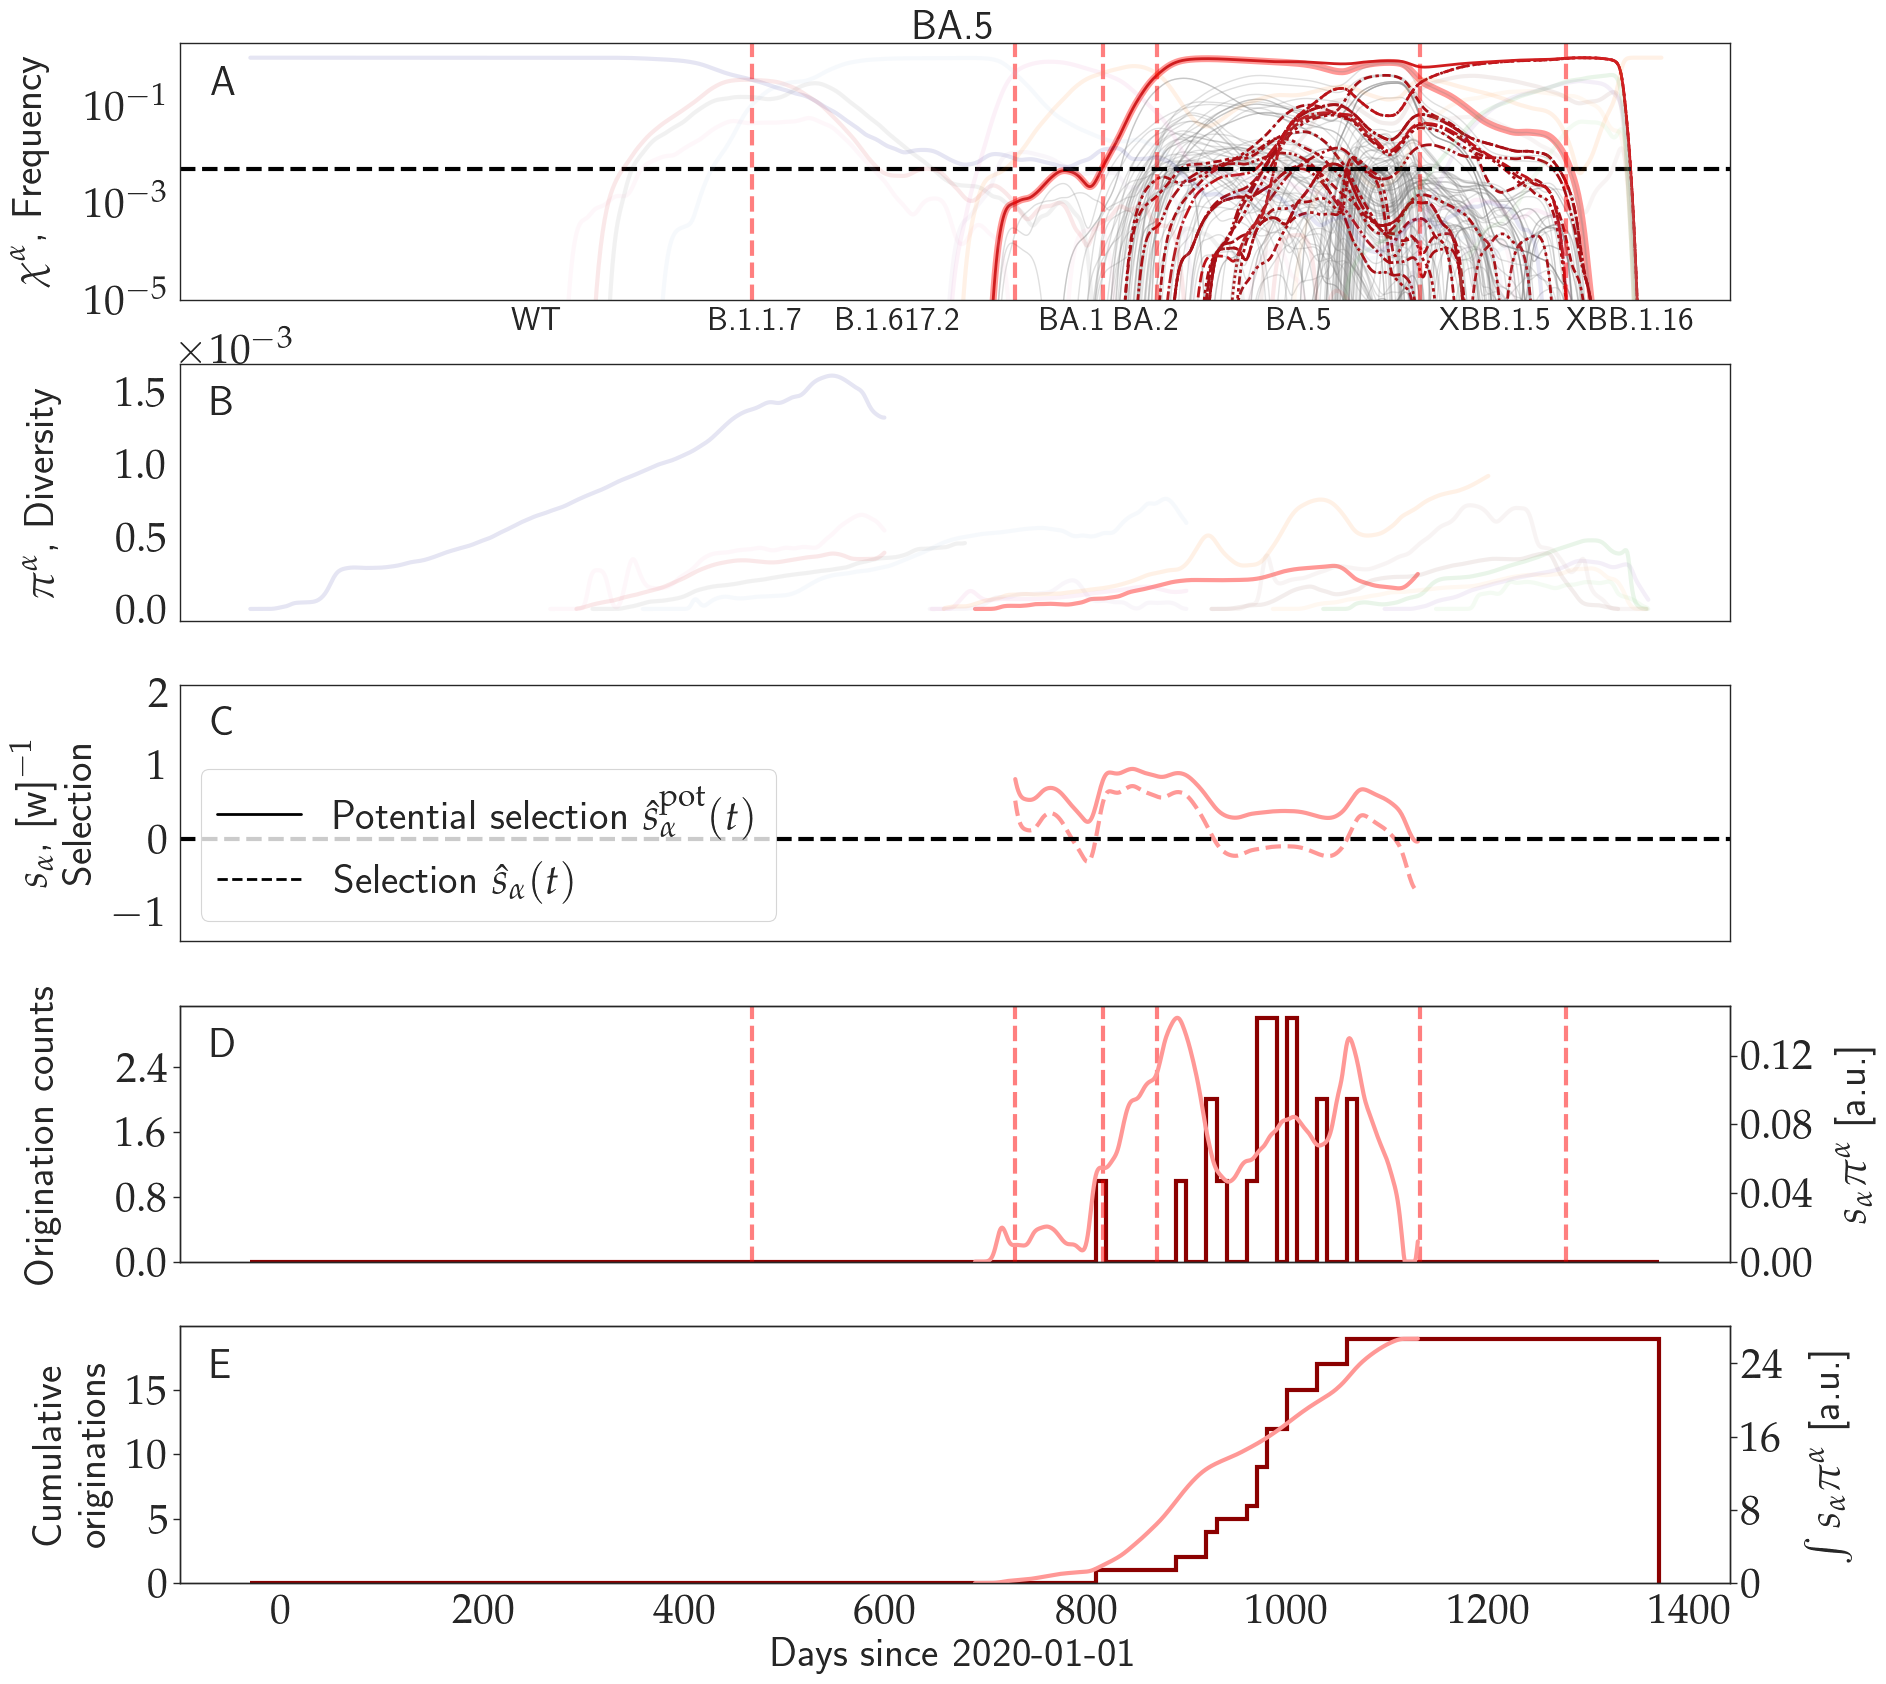

In [34]:

%autoreload
mosaic = """
AAAA
BBBB
CCCC
DDDD
EEEE
"""

fig,ax= plt.subplot_mosaic(mosaic,figsize=(20,20))
plt.subplots_adjust(hspace = 0.25, wspace = 0.05)

x_thresh = 5e-3
variant_name = 'BA.5'
tax1, tax2 = put.plot_single_variant_statistics_full( variant_name = variant_name, x_thresh = x_thresh,
    obs = 'f_pot_times_diversity',
    variant_axis = ax['A'], diversity_axis = ax['B'], selection_axis = ax['C'],
    counts_axis = ax['D'], cumulative_axis = ax['E'],
    clade_statistics_df = global_clade_statistics_SARS_CoV_2_World,
    variant_freqs_df = global_variants_df,
    fit_and_div_df = cleaned_selection_diversity_df,
    variant_color_dict = color_dict,
    S_RBD_palette = S_RBD_palette,
    crossover_times = equal_freq_times,
    bin_size = 10, max_times = True,
    pot_sel_name = 'smoothed_s_logit_pot_week',sel_name='smoothed_s_logit_week', 
    freq_axis_scale = 'log',
    )

sns.lineplot(data = global_variants_df[global_variants_df['Pango_Variant'] != variant_name],
            x= 'day_diff',
            y = 'Freq',
            hue = 'Pango_Variant',
            ax = ax['A'], palette = color_dict,alpha= .1,
            legend=False)

sns.lineplot(data = cleaned_selection_diversity_df[cleaned_selection_diversity_df['Pango_Variant'] != variant_name].query(f'day_diff < max_times'),
             x= 'day_diff',
             y = 'diversity',
             hue = 'Pango_Variant',
             ax = ax['B'], palette = color_dict,alpha= .1,
             legend=False)

# sns.lineplot(data = cleaned_selection_diversity_df[
#     cleaned_selection_diversity_df['Pango_Variant'] != variant_name].query(f'350 < day_diff < max_times & Freq > 1e-3' ),
#              x= 'day_diff',
#              y = 's_logit_week',
#              hue = 'Pango_Variant',
#              ax = ax['C'], palette = color_dict,alpha= .1,
#              ls='--',
#              legend=False)

for a in ['A','B','C','D']:
    ax[a].set_xlabel('')
    ax[a].set_xticklabels([])
    ax[a].tick_params(axis='both', which='both', labelsize=30)
    if ax[a].get_yscale() == 'linear':
        ax[a].yaxis.set_major_locator(plt.MaxNLocator(4))
    else:
        ax[a].yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4)) 
ax['E'].tick_params(axis='both', which='both', labelsize=30)
#increase number of ticks
ax['E'].yaxis.set_major_locator(plt.MaxNLocator(4))
ax['B'].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


offset_text = ax['B'].yaxis.get_offset_text()
offset_text.set_fontsize(30)
offset_text.set_position((offset_text.get_position()[0], offset_text.get_position()[1] + 2.3))


ax['A'].set_ylabel(r'$\chi^\alpha$, Frequency', fontsize = 30, labelpad = 25)
ax['B'].set_ylabel(r'$\pi^\alpha$, Diversity', fontsize = 30, labelpad = 40)
ax['C'].set_ylabel(r'$s_\alpha$, [w]$^{-1}$'+ '\n Selection', fontsize = 30, labelpad = 10)
ax['D'].set_ylabel('Origination counts', fontsize = 30, labelpad = 40)

ax['E'].set_xlabel('Days since 2020-01-01', fontsize = 30)
ax['E'].set_ylabel('Cumulative \n originations', fontsize = 30, labelpad = 10)

handles_selection  = [Line2D([0], [0], color='black', lw=2, linestyle = '-', label=r'Potential selection $\hat{s}_\alpha^{\mathrm{pot}}(t)$'),
                    Line2D([0], [0], color='black', lw=2, linestyle = '--', label=r'Selection $\hat{s}_\alpha(t)$')]
ax['C'].legend(handles = handles_selection, fontsize = 30, loc = 'lower left')
                      

tax1.set_ylabel(r'$s_\alpha\pi^\alpha$ [a.u.]' , fontsize = 30, labelpad = 15)
tax2.set_ylabel(r'$\int s_\alpha\pi^\alpha$ [a.u.]', fontsize = 30, labelpad = 15)

tax1.tick_params(axis='both', which='both', labelsize=30)
tax2.tick_params(axis='both', which='both', labelsize=30)
tax1.yaxis.set_major_locator(plt.MaxNLocator(4))
tax2.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim1 = ax['D'].get_ylim()
ylim2 = ax['E'].get_ylim()

ylim_tax1 = tax1.get_ylim()
ylim_tax2 = tax2.get_ylim()

for a in ['A','B','C','D','E']:
    ax[a].annotate(a, xy=(0.02, 0.8), xycoords="axes fraction", fontsize=30)
tax1.set_ylim(ylim_tax1[0]/(ylim1[1]/ylim_tax1[1]),ylim_tax1[1])

tax2.set_ylim(np.max((ylim_tax2[0]/(ylim2[1]/ylim_tax2[1]),0)),ylim_tax2[1])

# plt.savefig(thesis_picture_folder + f'/fig9_{variant_name}_full.pdf', bbox_inches = 'tight')




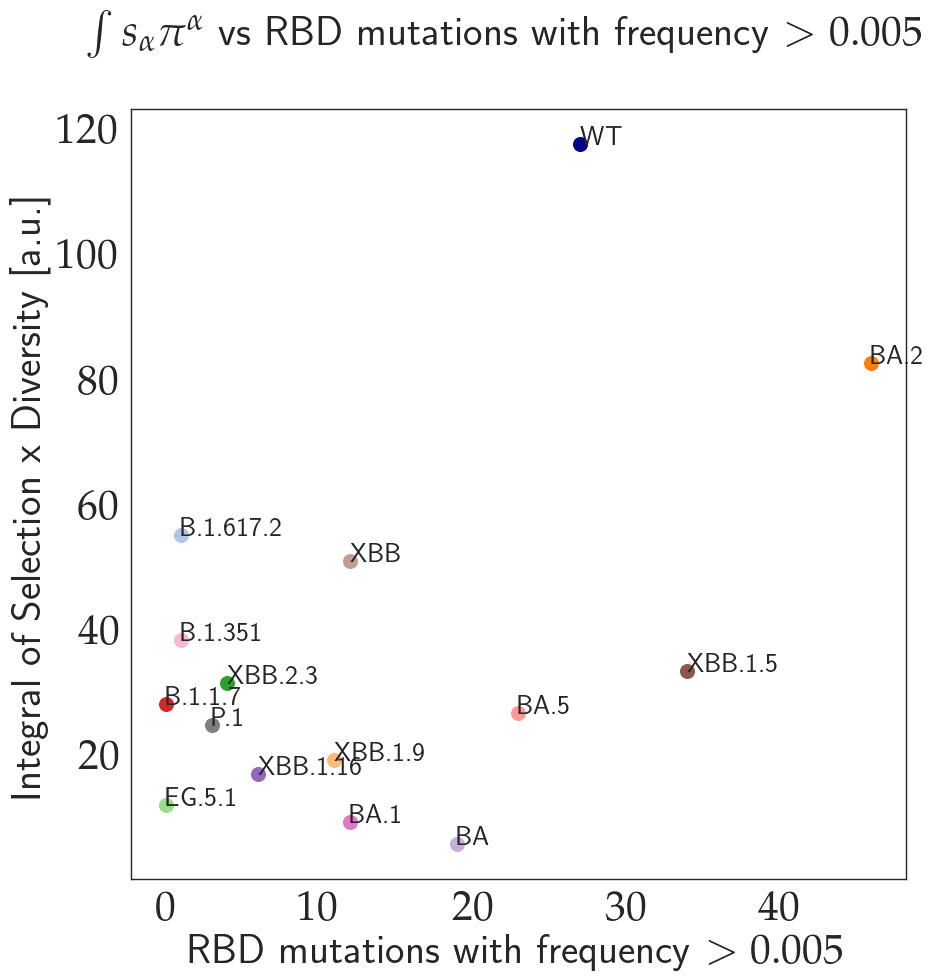

In [35]:

for x_thresh in [5e-3]:
    fig,ax = plt.subplots(1,1,figsize=(10,10),sharex = True)
    for var in driver_mutation_statistics.Pango_Variant.unique():
        # if var == 'BA.2' or var == 'BA':
        #     continue

        xpos = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & Max_Realized_Sublineage_Freq > {x_thresh}')['S_RBD'].sum()
        ypos = cleaned_selection_diversity_df.query(f'Pango_Variant == "{var}" & day_diff < max_times').f_pot_times_diversity.sum()

        ax.scatter(xpos,ypos, label = var, color = color_dict[var], s = 100)
        ax.annotate(var, (xpos,ypos), fontsize = 20)

        ax.set_xlabel(fr'RBD mutations with frequency $> {x_thresh}$', fontsize = 30)
        ax.set_ylabel('Integral of Selection x Diversity [a.u.]', fontsize = 30)
        ax.tick_params(axis='both', which='major', labelsize=30)
        # ax.set_xlim(-2,25)
    fig.suptitle(fr'$\int s_\alpha \pi^\alpha$ vs RBD mutations with frequency $> {x_thresh}$')
    # plt.savefig(thesis_picture_folder + f'/fig10_{x_thresh}.pdf', bbox_inches = 'tight')

    fig,ax = plt.subplots(1,1,figsize=(10,10),sharex = True)
    for var in driver_mutation_statistics.Pango_Variant.unique():
        # if var == 'BA.2' or var == 'BA':
        #     continue

        RBD_x= driver_mutation_statistics.query(f'Pango_Variant == "{var}" & Max_Realized_Sublineage_Freq > {x_thresh}')['S_RBD'].sum()
        RBD_0 = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & Max_Realized_Sublineage_Freq > 0')['S_RBD'].sum()
        syn_x = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & Max_Realized_Sublineage_Freq > {x_thresh} & nonsyn_weight == 0')['syn_weight'].sum()
        syn_0 = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & Max_Realized_Sublineage_Freq > 0 & nonsyn_weight == 0')['syn_weight'].sum()

        xpos = (RBD_x/RBD_0) / (syn_x/syn_0)
        ypos = cleaned_selection_diversity_df.query(f'Pango_Variant == "{var}" & day_diff < max_times').f_pot_times_diversity.sum()

        ax.scatter(xpos,ypos, label = var, color = color_dict[var], s = 100)
        ax.annotate(var, (xpos,ypos), fontsize = 20)

        ax.set_xlabel(fr'g factor frequency $> {x_thresh}$')
        ax.set_ylabel('Integral of Selection x Diversity [a.u.]')
        # ax.set_xlim(-2/10,3)
    fig.suptitle(fr'$\int s_\alpha \pi^\alpha$ vs g factor with frequency $> {x_thresh}$')

In [36]:
ylim_tax2[0]/(ylim2[1]/ylim_tax2[1]),ylim_tax2[1], ylim2

(-1.8777659539829652, 28.04799540824911, (0.0, 19.95))

In [37]:
np.max((ylim_tax2[0]/(ylim2[1]/ylim_tax2[1]),0)),ylim_tax2[1]


(0.0, 28.04799540824911)

In [38]:
%autoreload
mosaic = """
AAAA.ZZ
AAAA.ZZ
BBBB.ZZ
CCCC.WW
DDDD.WW
EEEE.WW
"""

fig,ax= plt.subplot_mosaic(mosaic,figsize=(30,15))
plt.subplots_adjust(hspace = 0.25, wspace = 0.05)

#def plot_single_variant_statistics_full(
    # obs, variant_name, x_thresh,
    # variant_axis, 
    # diversity_axis, selection_axis,
    # counts_axis, cumulative_axis,
    # clade_statistics_df, variant_freqs_df, fit_and_div_df,
    # variant_color_dict, S_RBD_palette,
    # crossover_times, bin_size, max_times = False,
    # sel_name = None, pot_sel_name = None
    # )

x_thresh = 5e-3
variant_name = 'BA.5'
put.plot_single_variant_statistics_full( variant_name = variant_name, x_thresh = x_thresh,
    obs = 'f_pot_times_diversity',
    variant_axis = ax['A'], diversity_axis = ax['B'], selection_axis = ax['C'],
    counts_axis = ax['D'], cumulative_axis = ax['E'],
    clade_statistics_df = global_clade_statistics_SARS_CoV_2_World,
    variant_freqs_df = global_variants_df,
    fit_and_div_df = cleaned_selection_diversity_df,
    variant_color_dict = color_dict,
    S_RBD_palette = S_RBD_palette,
    crossover_times = equal_freq_times,
    bin_size = 10, max_times = True)


######## inverse cumulative density frequency distribution axis
ax['Z'].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}"')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}"')['S_RBD'],
    bins = np.logspace(-6,0,100),
    color='darkred',
    cumulative = -1,
    density= True,
    lw=3,
    histtype = 'step',
    label = 'RBD mutations')

ax['Z'].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}" & nonsyn_weight == 0')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}" & nonsyn_weight == 0')['syn_weight'],
    bins = np.logspace(-6,0,100),
    color='grey',
    cumulative = -1,
    density= True,
    lw=3,
    histtype = 'step',
    label = 'Synonymous')

######## inverse cumulative count frequency distribution axis
hW_RBD,bw_RBD,pw_RBD = ax['W'].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}"')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}"')['S_RBD'],
    bins = np.logspace(-6,0,100),
    color='darkred',
    cumulative = -1,
    density= False,
    lw=3,
    histtype = 'step',
    label = 'RBD mutations')

hW_syn,bw_syn,pw_syn = ax['W'].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}" & nonsyn_weight == 0')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{variant_name}" & nonsyn_weight == 0')['syn_weight'],
    bins = np.logspace(-6,0,100),
    color='grey',
    cumulative = -1,
    density= False,
    lw=3,
    histtype = 'step',
    label = 'Synonymous')

ax['Z'].set_xscale('log')
ax['Z'].set_yscale('log')
ax['Z'].set_xlabel('Maximum sublineage frequency', fontsize = 20)
ax['Z'].set_ylabel('Cumulative fraction of sublineages', fontsize = 20)
ax['Z'].set_xlim(1e-6,1)
ax['Z'].legend(loc='best', fontsize = 20)
ax['Z'].axvline(x_thresh, color = 'black', linestyle = '--', lw = 3)

ind_RBD_thresh = np.where(bw_RBD > x_thresh)[0][0]
ind_syn_thresh = np.where(bw_syn > x_thresh)[0][0]

ax['W'].annotate(f'{hW_RBD[ind_RBD_thresh]:.0f}', (x_thresh*1.5,hW_RBD[ind_RBD_thresh]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 25, color = 'darkred')
ax['W'].annotate(f'{hW_syn[ind_syn_thresh]:.0f}', (x_thresh*1.5,hW_syn[ind_syn_thresh]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 25, color = 'grey')

ax['W'].set_xscale('log')
ax['W'].set_yscale('log')
ax['W'].set_xlabel('Maximum sublineage frequency', fontsize = 20)
ax['W'].set_ylabel('Cumulative number of sublineages', fontsize = 20)
ax['W'].set_xlim(1e-6,1)
ax['W'].legend(loc='best', fontsize = 20)
ax['W'].axvline(x_thresh, color = 'black', linestyle = '--', lw = 3)

for a in ['A','B','C','D']:
    ax[a].set_xlabel('')
    ax[a].set_xticklabels([])
ax['E'].set_xlabel('Days since 2020-01-01', fontsize = 20)
ax['E'].set_ylabel('Cumulative number of sublineages', fontsize = 20)


Text(0, 0.5, 'Cumulative number of sublineages')

In [39]:
var ='WT'
fig,ax = plt.subplots(1,2,figsize=(20,5),sharex = True)

ax[1].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{var}"')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{var}"')['S_RBD'],
    bins = np.logspace(-6,0,100),
    color='darkred',
    cumulative = -1,
    density= True,
    lw=3,
    histtype = 'step',
    label = 'RBD mutations')

ax[1].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{var}" & nonsyn_weight == 0')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & nonsyn_weight == 0')['syn_weight'],
    bins = np.logspace(-6,0,100),
    color='grey',
    cumulative = -1,
    density= True,
    lw=3,
    histtype = 'step',
    label = 'Synonymous')

######## inverse cumulative count frequency distribution axis
hW_RBD,bw_RBD,pw_RBD = ax[0].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{var}"')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{var}"')['S_RBD'],
    bins = np.logspace(-6,0,100),
    color='darkred',
    cumulative = -1,
    density= False,
    lw=3,
    histtype = 'step',
    label = 'RBD mutations')

hW_syn,bw_syn,pw_syn = ax[0].hist(
    driver_mutation_statistics.query(f'Pango_Variant == "{var}" & nonsyn_weight == 0')['Max_Realized_Sublineage_Freq'],
    weights = driver_mutation_statistics.query(f'Pango_Variant == "{var}" & nonsyn_weight == 0')['syn_weight'],
    bins = np.logspace(-6,0,100),
    color='grey',
    cumulative = -1,
    density= False,
    lw=3,
    histtype = 'step',
    label = 'Synonymous')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Maximum sublineage frequency', fontsize = 20)
ax[1].set_ylabel('Cumulative fraction of sublineages', fontsize = 20)
ax[1].set_xlim(1e-6,1)
ax[1].legend(loc='best', fontsize = 20)
ax[1].axvline(x_thresh, color = 'black', linestyle = '--', lw = 3)

ind_RBD_thresh = np.where(bw_RBD > x_thresh)[0][0]
ind_syn_thresh = np.where(bw_syn > x_thresh)[0][0]

ax[0].annotate(f'{hW_RBD[ind_RBD_thresh]:.0f}', (x_thresh*1.5,hW_RBD[ind_RBD_thresh]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 25, color = 'darkred')
ax[0].annotate(f'{hW_syn[ind_syn_thresh]:.0f}', (x_thresh*1.5,hW_syn[ind_syn_thresh]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 25, color = 'grey')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Maximum sublineage frequency', fontsize = 20)
ax[0].set_ylabel('Cumulative number of sublineages', fontsize = 20)
ax[0].set_xlim(1e-6,1)
ax[0].legend(loc='best', fontsize = 20)
ax[0].axvline(x_thresh, color = 'black', linestyle = '--', lw = 3)


NameError: name 'thesis_picture_folder' is not defined

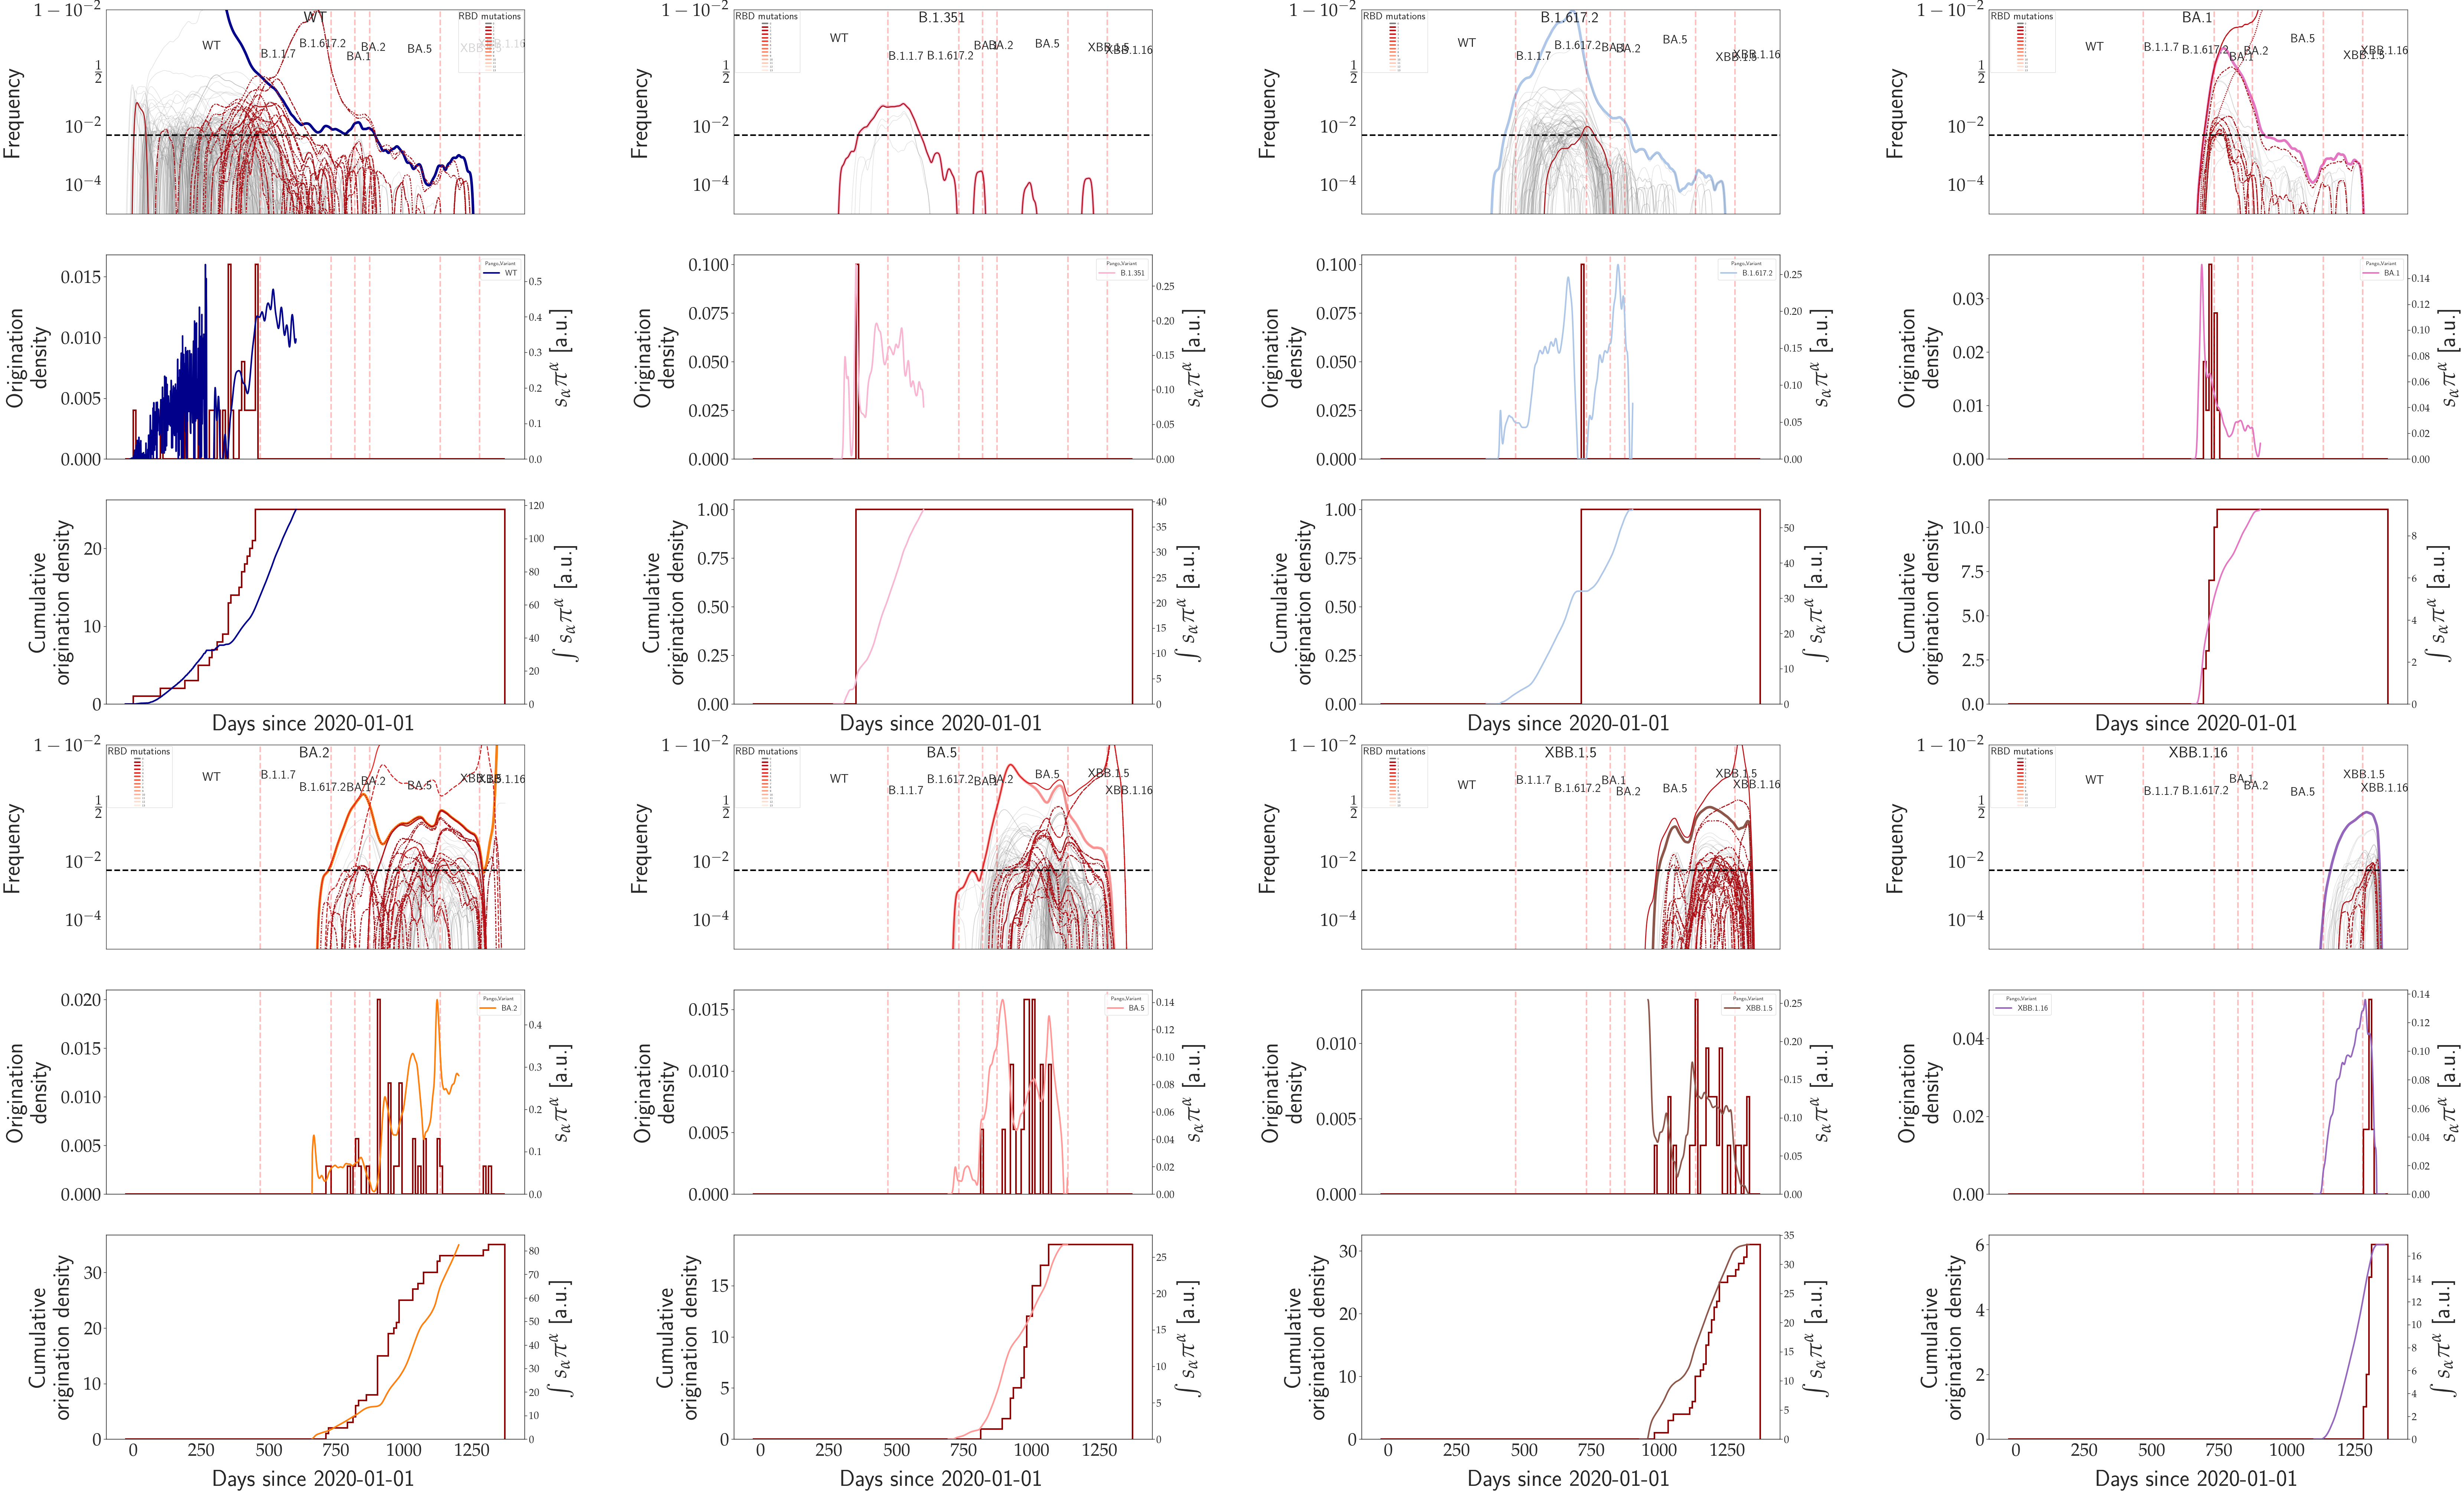

In [40]:
%autoreload

fig,ax, tax = put.plot_variant_statistics(
    obs = 'f_pot_times_diversity',
    clade_statistics_df=global_clade_statistics_SARS_CoV_2_World,
    variant_freqs_df=global_variants_df,
    fit_and_div_df=cleaned_selection_diversity_df,
    variant_color_dict=color_dict,
    S_RBD_palette=S_RBD_palette,
    crossover_times=equal_freq_times,
    bin_size=10,
    x_thresh = 5e-3,
    max_times = True, figsize=(80,50))
plt.savefig(thesis_picture_folder + '/SI_variant_statistics.pdf', bbox_inches='tight', dpi=300)

In [ ]:
%autoreload 


fig,ax, tax = put.plot_variant_statistics(
    obs = 'f_pot_times_diversity',
    clade_statistics_df=global_clade_statistics_SARS_CoV_2_World,
    variant_freqs_df=global_variants_df,
    fit_and_div_df=cleaned_selection_diversity_df,
    variant_color_dict=color_dict,
    S_RBD_palette=S_RBD_palette,
    crossover_times=equal_freq_times,
    bin_size=10,
    x_thresh = 5e-3,
    max_times = True, figsize=(80,50))

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True)
sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< 1300'),
    x = 'day_diff',
    y = 'Freq',
    hue = 'Pango_Variant',
    palette = color_dict,
    ax = ax[0],legend=False)

sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< max_times & day_diff< 1300 & Freq > 2e-2'),
    x = 'day_diff',
    y = 'smoothed_s_logit_week',
    hue = 'Pango_Variant',
    palette = color_dict,
    
    ax = ax[1],legend=False)

sns.lineplot(data = cleaned_selection_diversity_df.query(f' 300 < day_diff< max_times & day_diff< 1300 & Freq > 2e-2'),
    x = 'day_diff',
    y = 'smoothed_s_logit_pot_week',
    hue = 'Pango_Variant',
    palette = color_dict,
    ls = '--',
    ax = ax[1],legend=False)

ax[1].axhline(0, color = 'black', linestyle = '--', alpha = 0.5)

for et in equal_freq_times:
    ax[0].axvline(et, color = 'black', linestyle = '--', alpha = 0.5)
    ax[1].axvline(et, color = 'black', linestyle = '--', alpha = 0.5)

for pv in [
            'WT', 'B.1.1.7', 'B.1.351', 'B.1.617.2',
            'BA.1', 'BA.2', 'BA.5', 'XBB', 'XBB.1.5', 'XBB.1.16'
        ]:
            ylim1 = ax[0].get_ylim()
            ypos = np.array(ylim1[1]) * np.random.uniform(0.01, 0.95)
            xpos = (
                cleaned_selection_diversity_df.query(f'Pango_Variant == "{pv}" & Freq > 0.1').day_diff.mean()
                if pv != 'BA.2' else 840
            )
            if pv == 'XBB.1.16':
                xpos+=30
            elif pv == 'BA.2':
                xpos+=20
            elif pv == 'WT':
                xpos+=70
            # ax.annotate(pv, xy=(xpos, ypos), fontsize=24)
            ax[0].annotate(
                pv,
                xy=(xpos, 1e-4),  # x=50% in axis coords, y=0 (bottom of axis)
                xycoords='data',
                textcoords='offset points',  # offset just the y position
                xytext=(0, -25),  # move only downward by 20 points
                ha='center', va='top',  # horizontal and vertical alignment,
                fontsize=24 
            )

ax[0].set_ylabel(r'$\chi^\alpha$, Frequency', fontsize = 30, labelpad = 55)
ax[1].set_ylabel(r'$\hat{s}_\alpha$, [w]$^{-1}$'+ '\n Selection', fontsize = 30, labelpad = 10)
ax[1].set_xlabel('Time, days since 2020-01-01', fontsize = 30, labelpad = 10)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=30)
    a.tick_params(axis='both', which='minor', labelsize=30)
    a.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig(thesis_picture_folder + '/SI_pots_selection_and_freqs.pdf', bbox_inches='tight', dpi=300)        